# Homework 3 - Improving the Pipeline 
# Part 2: Analysis

CAPP 30235 Machine Learning for Public Policy

Jonathan Tan

May 2, 2019

## 0. Setup

In [1]:
# Setup autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale

# Import pipeline library, hardcoded config file values
import pipeline_library as library
import pipeline_config as config

## 1. Read data

In [3]:
df = library.read_data(config.DATA_PATH)
print(df.shape)
df.head()

(124976, 26)


,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [4]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded'],
      dtype='object')

## 2. Explore data

### 2.1 What is the baseline rate for being funded within 60 days?

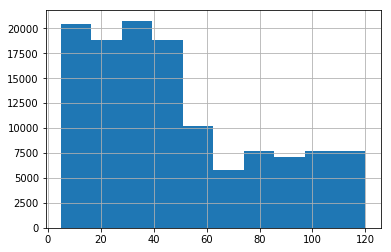

In [5]:
# Histogram of number of days to being fully funded
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%m/%d/%y')
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'], format='%m/%d/%y')
df['days_to_funded'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['days_to_funded'].hist()

In [6]:
# What percentage of projects are funded within 60 days?
len(df.loc[df['days_to_funded'] <= 60]) / len(df)

0.7118646780181795

In [7]:
to_plot = ['school_state', 'school_metro', 'school_charter', 'school_magnet', 
           'teacher_prefix', 'primary_focus_area', 'secondary_focus_area',
           'resource_type', 'poverty_level', 'grade_level',
           'total_price_including_optional_support', 'students_reached',
           'eligible_double_your_impact_match']

# library.plot_distributions(df, varlist=to_plot)

In [8]:
numeric_features = ['total_price_including_optional_support', 'students_reached']

library.describe_data(df, varlist=numeric_features)

,total_price_including_optional_support,students_reached
count,124976.000000,124917.000000
mean,654.011811,95.445760
std,1098.015854,163.481912
min,92.000000,1.000000
25%,345.810000,23.000000
50%,510.500000,30.000000
75%,752.960000,100.000000
max,164382.840000,12143.000000


## 3. Pre-process data / Generate features/predictors

To avoid pre-processing data that will be omitted from the training data, below I pre-select the features I want to use and focus on cleaning those.

Data cleaning steps:
1. Select features to be used in final model(s)
2. Define label: `funded_in_60_days`
3. Clean missing data
4. Normalize numeric data
5. Make binary data into true binary
6. Make categorical data into dummies

### 3.1 Select features for the final model(s)

Here, I've excluded extraneous features like the ID columns and lat/long data, as well as geographical features like `school_district` and `school_city` that should be highly collinear with the remaining `school_county` and `school_state` features.

In [9]:
selected_features = ['school_county', 'school_state', 'school_metro', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_area', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded']

df = df[selected_features]

### 3.2 Define label: `funded_in_60_days`

In [10]:
df['fully_funded_in_60_days'] = \
    (df['datefullyfunded'] - df['date_posted'] <= pd.to_timedelta(60, unit='days')).astype('int')

df[['date_posted', 'datefullyfunded', 'fully_funded_in_60_days']].head()

,date_posted,datefullyfunded,fully_funded_in_60_days
0,2013-04-14,2013-05-02,1
1,2012-04-07,2012-04-18,1
2,2012-01-30,2012-04-15,0
3,2012-10-11,2012-12-05,1
4,2013-01-08,2013-03-25,0


In [11]:
df = df.drop(labels=['datefullyfunded'], axis=1)

### 3.3 Clean missing data

First, let's see which columns are missing data.

In [ ]:
df.isnull().sum(axis=0)

school_county                                 0
school_state                                  0
school_metro                              15224
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_area                           15
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                                   0
fully_funded_in_60_days                       0
dtype: int64

In [ ]:
# school_metro - 15224 missing, categorical - leave as is
# primary_focus_area - 15 missing, categorical - leave as is
# secondary_focus_area - 40556 missing, categorical - leave as is
# resource_type - 17 missing, categorical - leave as is
# grade_level - 3 missing, leave as is

# students_reached - 59 missing, integer, fill with mean
df['students_reached'] = library.fill_missing(df['students_reached'])

### 3.4 Rescale/standardize numeric data

In [ ]:
for i in numeric_features:
    df[i] = scale(df[i])
    
df[numeric_features].describe()

,total_price_including_optional_support,students_reached
count,1.249760e+05,1.249760e+05
mean,-5.330760e-17,8.715237e-17
std,1.000004e+00,1.000004e+00
min,-5.118451e-01,-5.778526e-01
25%,-2.806909e-01,-4.432488e-01
50%,-1.307016e-01,-3.943019e-01
75%,9.011581e-02,2.786445e-02
max,1.491140e+02,7.371120e+01


### 3.5 Make binary data into true binary format

The `school_charter`, `school_magnet` and `eligible_double_your_impact_match` features are also binary variables coded as string variables ("t" or "f"), so we'll convert them to a true binary variable.

In [ ]:
binary_features = ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']

for i in binary_features:
    df[i] = np.where(df[i] == 't', 1, 0)

df[binary_features].head()

,school_charter,school_magnet,eligible_double_your_impact_match
0,0,0,0
1,0,0,1
2,0,0,0
3,0,1,0
4,0,0,0


### 3.6 Make categorical data into dummies

In [ ]:
categorical_features = ['school_county', 'school_state', 'school_metro', 'teacher_prefix', \
                        'resource_type', 'primary_focus_area', 'secondary_focus_area', \
                        'poverty_level', 'grade_level']

for i in categorical_features:
    df = library.make_dummy_vars(df, i)

df.head()

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,fully_funded_in_60_days,school_county_Abbeville,school_county_Acadia,school_county_Accomack,...,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
0,0,0,0.769207,-0.394302,0,2013-04-14,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,-0.338377,-0.412657,1,2012-04-07,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0.326379,-0.241343,0,2012-01-30,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0,1,-0.435953,-0.443249,0,2012-10-11,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,2.674925,0.333782,0,2013-01-08,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
df.shape

(124976, 1563)

In [ ]:
df.columns

Index(['school_charter', 'school_magnet',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted',
       'fully_funded_in_60_days', 'school_county_Abbeville',
       'school_county_Acadia', 'school_county_Accomack',
       ...
       'secondary_focus_area_Music & The Arts',
       'secondary_focus_area_Special Needs', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2'],
      dtype='object', length=1563)

## 4. Build and evaluate classifiers

Model building and validation steps:
1. Split data into test and train temporal sets
2. Train series of classifiers on training data, then print evaluation metrics

### 4.1 Split data into test and train sets by time

In [ ]:
# Get three different temporal test/train sets and append to list
test_train = []
TEST_DUR = 6
TEST_UNITS = 'M'
new_df = df.copy(deep=True)

while True:
    # split_data_temporal returns (x_train, x_test, y_train, y_test)
    data = library.split_data_temporal(new_df, label=config.LABEL, date_col='date_posted', \
                                       test_dur=TEST_DUR, test_units=TEST_UNITS)
    test_train.append(data)
    
    # if length of training set is shorter than length of test set, break
    train_length = data[0]['date_posted'].max() - data[0]['date_posted'].min()
    test_length = data[1]['date_posted'].max() - data[1]['date_posted'].min()
    
    if train_length <= test_length:
        break
    else:
        new_max = new_df['date_posted'].max() - pd.to_timedelta(TEST_DUR, TEST_UNITS)
        new_df = new_df.loc[new_df['date_posted'] < new_max]

In [ ]:
# Make sure temporal splits worked correctly
# Each entry in list is a 4-tuple of (x_train, x_test, y_train, y_test)
# Drop date_posted field after validating

for i in range(len(test_train)):
    train_start = test_train[i][0]['date_posted'].min().date()
    train_end = test_train[i][0]['date_posted'].max().date()
    train_dur = train_end - train_start
    test_start = test_train[i][1]['date_posted'].min().date()
    test_end = test_train[i][1]['date_posted'].max().date()
    test_dur = test_end - test_start
    print(f'TRAINING SET {i + 1}: start: {train_start}, end: {train_end}, dur: {train_dur}')
    print(f'TEST SET {i + 1}: start: {test_start}, end: {test_end}, dur: {test_dur}')
    print('')

TRAINING SET 1: start: 2012-01-01, end: 2013-07-01, dur: 547 days, 0:00:00
TEST SET 1: start: 2013-07-02, end: 2013-12-31, dur: 182 days, 0:00:00

TRAINING SET 2: start: 2012-01-01, end: 2012-12-30, dur: 364 days, 0:00:00
TEST SET 2: start: 2012-12-31, end: 2013-07-01, dur: 182 days, 0:00:00

TRAINING SET 3: start: 2012-01-01, end: 2012-06-30, dur: 181 days, 0:00:00
TEST SET 3: start: 2012-07-01, end: 2012-12-30, dur: 182 days, 0:00:00



### 4.2 Train and evaluate classifiers

In [ ]:
# Set test/train splits, classifiers, precision-recall thresholds to loop over
classifiers = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
               'LinearSVC', 'RandomForestClassifier', 'AdaBoostClassifier', 
               'BaggingClassifier']
pr_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
results_df = pd.DataFrame()

# Loop
for i in classifiers:
    for j in test_train:
        # select correct test-train split
        x_train, x_test, y_train, y_test = j
        
        test_start = str(x_test['date_posted'].min().date())
        test_end = str(x_test['date_posted'].max().date())
        
        # drop date cols before training
        x_train = x_train.drop(labels=['date_posted'], axis=1)
        x_test = x_test.drop(labels=['date_posted'], axis=1)

        # train model
        trained = library.train_classifier(x_train, y_train, 
                                           method=i, 
                                           param_dict=config.MODEL_PARAMS)

        # evalute results
        results_dict = library.validate_classifier(x_test, y_test, trained,
                                                  pr_threshold=pr_thresholds)
        results_dict['test-start'] = test_start
        results_dict['test-end'] = test_end

        # save to dict
        results_df = results_df.append(results_dict, ignore_index=True)

Training LogisticRegression with params {'penalty': 'l1', 'solver': 'liblinear', 'random_state': 0}
Training LogisticRegression with params {'penalty': 'l1', 'solver': 'liblinear', 'random_state': 0}
Training LogisticRegression with params {'penalty': 'l1', 'solver': 'liblinear', 'random_state': 0}
Training KNeighborsClassifier with params {'weights': 'distance'}


In [ ]:
results_df.set_index(['classifier', 'test-start', 'test-end'])

In [ ]:
# Plot precision-recall curves. Code adapted from Lab 4.

from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve

# Train
bagging = BaggingClassifier() # use the default parameters: base_estimator is a decision tree, n_estimators=10
bagging.fit(x_train, y_train)
y_scores = bagging.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
population = [sum(y_scores > threshold)/len(y_scores) for threshold in thresholds]

# Plot
p, = plt.plot(population, precision[:-1], color='b')
r, = plt.plot(population, recall[:-1], color='r')
plt.legend([p, r], ['precision', 'recall'])
plt.savefig('output/test.png', format='png')

to do:
1. tune individual model parameters
2. output roc-auc curves properly